# Step 1 - openAI and TA4H connection
Let's see that OpenAI works:
Use GitHubs's settings->security->Secrets and Variables to set the 3 secrets: 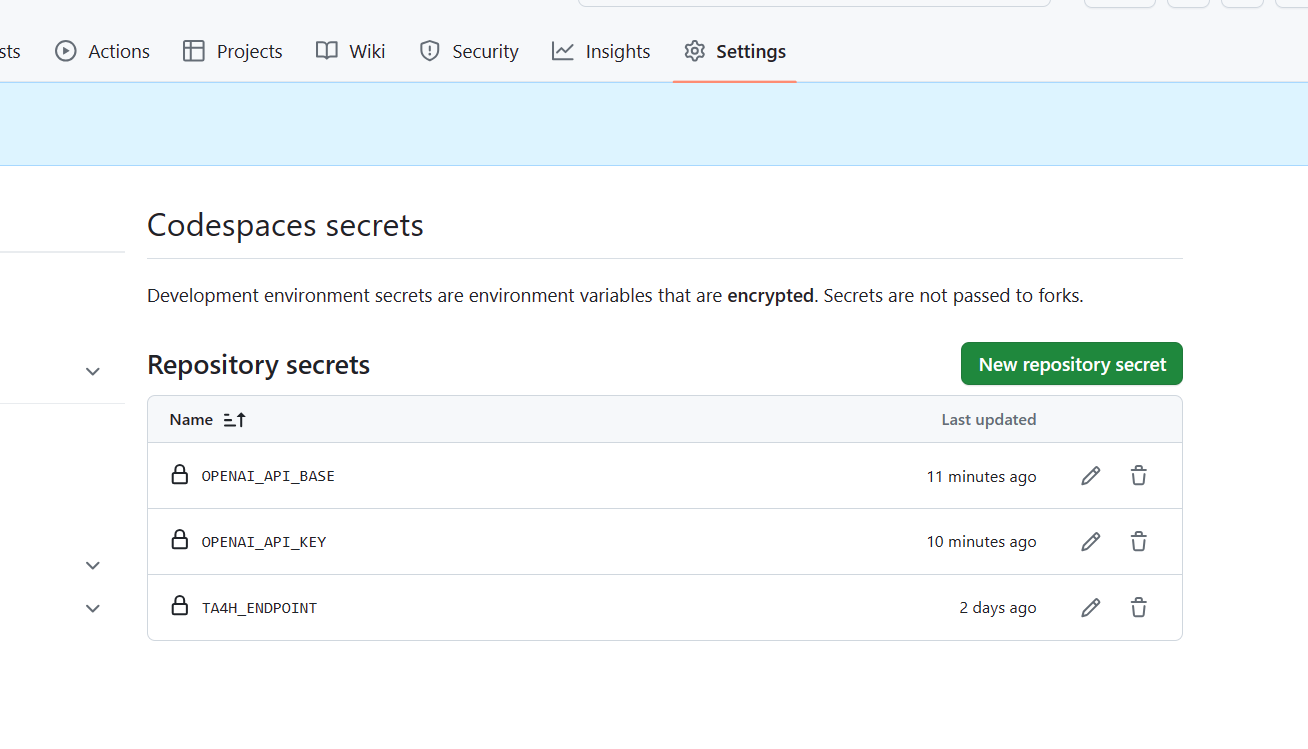
Then run this:


In [20]:
import openai
import os

openai.api_type = "azure"
openai.api_base = os.getenv("OPENAI_API_BASE")
openai.api_version = "2023-07-01-preview"
openai.api_key = os.getenv("OPENAI_API_KEY")
from tech_train_functions import call_open_ai


In [4]:
call_open_ai(system_message="You're an AI assistant", text="please write names of 3 animals")


'Lion, Elephant, Giraffe.'

You got 3 animals? Great!
Now TA4H check:

In [8]:
from tech_train_functions import TA4HPredictor
ta4h = TA4HPredictor()
entities = ta4h.predict_ta4h(["The patient has arm fracture"])
print(entities[0][0]["name"])

Fracture of upper limb


Got "Fracture of upper limb"? Great! Step 1 done

## Step 2 - Load Dataset and run first iteration
Load MedQA dev split:

In [93]:
import pandas as pd
from tqdm import tqdm
pd.set_option('max_colwidth', 1000)
pd.options.mode.chained_assignment = None
df_dev = pd.read_csv("../data/MedQA_dev.csv", index_col=0)
df_train = pd.read_csv("../data/MedQA_train.csv", index_col=0)
df_dev.head(2)


,question,answer,answer_idx,options,meta_info
0,"A 21-year-old sexually active male complains of fever, pain during urination, and inflammation and pain in the right knee. A culture of the joint fluid shows a bacteria that does not ferment maltose and has no polysaccharide capsule. The physician orders antibiotic therapy for the patient. The mechanism of action of action of the medication given blocks cell wall synthesis, which of the following was given?",Ceftriaxone,C,"{'A': 'Gentamicin', 'B': 'Ciprofloxacin', 'C': 'Ceftriaxone', 'D': 'Trimethoprim'}",step1
1,"A 5-year-old girl is brought to the emergency department by her mother because of multiple episodes of nausea and vomiting that last about 2 hours. During this period, she has had 6–8 episodes of bilious vomiting and abdominal pain. The vomiting was preceded by fatigue. The girl feels well between these episodes. She has missed several days of school and has been hospitalized 2 times during the past 6 months for dehydration due to similar episodes of vomiting and nausea. The patient has lived with her mother since her parents divorced 8 months ago. Her immunizations are up-to-date. She is at the 60th percentile for height and 30th percentile for weight. She appears emaciated. Her temperature is 36.8°C (98.8°F), pulse is 99/min, and blood pressure is 82/52 mm Hg. Examination shows dry mucous membranes. The lungs are clear to auscultation. Abdominal examination shows a soft abdomen with mild diffuse tenderness with no guarding or rebound. The remainder of the physical examination sho...",Cyclic vomiting syndrome,A,"{'A': 'Cyclic vomiting syndrome', 'B': 'Gastroenteritis', 'C': 'Hypertrophic pyloric stenosis', 'D': 'Gastroesophageal reflux disease'}",step2&3


In [26]:
#create small sample for experiments:
df_dev_sample = df_dev[:30]

Now let's run our first inference!

Here we're supplying GPT with questions, options for answers, and that's all

In [31]:
system_message = "You're a medical expert answering medical questions. \
Answer with only the correct answer and nothing else, not even the index of the answer."
sample_list = (df_dev_sample["question"]+" "+
                df_dev_sample["options"].astype(str)).tolist()
print("Input example:{}".format(sample_list[0]))


replies = []
for q in tqdm(sample_list):
    ans = call_open_ai(system_message, q)
    replies.append(ans)
df_dev_sample.loc[:,"reply"] = replies

Input example:A 21-year-old sexually active male complains of fever, pain during urination, and inflammation and pain in the right knee. A culture of the joint fluid shows a bacteria that does not ferment maltose and has no polysaccharide capsule. The physician orders antibiotic therapy for the patient. The mechanism of action of action of the medication given blocks cell wall synthesis, which of the following was given? {'A': 'Gentamicin', 'B': 'Ciprofloxacin', 'C': 'Ceftriaxone', 'D': 'Trimethoprim'}


100%|██████████| 30/30 [00:08<00:00,  3.70it/s]


Let's check our answers:

In [32]:
df_dev_sample.head(3)

,question,answer,answer_idx,options,meta_info,reply
0,"A 21-year-old sexually active male complains of fever, pain during urination, and inflammation and pain in the right knee. A culture of the joint fluid shows a bacteria that does not ferment maltose and has no polysaccharide capsule. The physician orders antibiotic therapy for the patient. The mechanism of action of action of the medication given blocks cell wall synthesis, which of the following was given?",Ceftriaxone,C,"{'A': 'Gentamicin', 'B': 'Ciprofloxacin', 'C': 'Ceftriaxone', 'D': 'Trimethoprim'}",step1,Ceftriaxone.
1,"A 5-year-old girl is brought to the emergency department by her mother because of multiple episodes of nausea and vomiting that last about 2 hours. During this period, she has had 6–8 episodes of bilious vomiting and abdominal pain. The vomiting was preceded by fatigue. The girl feels well between these episodes. She has missed several days of school and has been hospitalized 2 times during the past 6 months for dehydration due to similar episodes of vomiting and nausea. The patient has lived with her mother since her parents divorced 8 months ago. Her immunizations are up-to-date. She is at the 60th percentile for height and 30th percentile for weight. She appears emaciated. Her temperature is 36.8°C (98.8°F), pulse is 99/min, and blood pressure is 82/52 mm Hg. Examination shows dry mucous membranes. The lungs are clear to auscultation. Abdominal examination shows a soft abdomen with mild diffuse tenderness with no guarding or rebound. The remainder of the physical examination sho...",Cyclic vomiting syndrome,A,"{'A': 'Cyclic vomiting syndrome', 'B': 'Gastroenteritis', 'C': 'Hypertrophic pyloric stenosis', 'D': 'Gastroesophageal reflux disease'}",step2&3,A: Cyclic vomiting syndrome.
2,"A 40-year-old woman presents with difficulty falling asleep, diminished appetite, and tiredness for the past 6 weeks. She says that, despite going to bed early at night, she is unable to fall asleep. She denies feeling anxious or having disturbing thoughts while in bed. Even when she manages to fall asleep, she wakes up early in the morning and is unable to fall back asleep. She says she has grown increasingly irritable and feels increasingly hopeless, and her concentration and interest at work have diminished. The patient denies thoughts of suicide or death. Because of her diminished appetite, she has lost 4 kg (8.8 lb) in the last few weeks and has started drinking a glass of wine every night instead of eating dinner. She has no significant past medical history and is not on any medications. Which of the following is the best course of treatment in this patient?",Trazodone,D,"{'A': 'Diazepam', 'B': 'Paroxetine', 'C': 'Zolpidem', 'D': 'Trazodone'}",step1,B: Paroxetine


As you can see it's not exactly like the gold answer... we'll be using a fuzzy  match function to assess if the reply is similar to gold answer:

In [38]:
from tech_train_functions import is_similar
df_dev_sample.loc[:,"is correct reply"] = df_dev_sample.apply(lambda row:is_similar(row["answer"], row["answer_idx"], row["reply"]), axis=1)


Let's see what is our accuracy:

In [39]:
df_dev_sample["is correct reply"].value_counts(normalize=True)

is correct reply
1    0.566667
0    0.433333
Name: proportion, dtype: float64

Better than 25% random but not too good... 

##
## STEP 3 - Chain of Thought

In [64]:
system_message_CoT = "You're a medical expert answering medical questions. Please answer step by step. Start with 'let's take it step by step'\
and end with 'the correct answer is:' and then the correct answer. Please allways end with this phrase"

sample_list = (df_dev_sample["question"]+" "+
                df_dev_sample["options"].astype(str)).tolist()
print("Input example:{}".format(sample_list[0]))


replies = []
for q in tqdm(sample_list):
    ans = call_open_ai(system_message_CoT, q)
    replies.append(ans)
df_dev_sample.loc[:,"reply_CoT"] = replies

Input example:A 21-year-old sexually active male complains of fever, pain during urination, and inflammation and pain in the right knee. A culture of the joint fluid shows a bacteria that does not ferment maltose and has no polysaccharide capsule. The physician orders antibiotic therapy for the patient. The mechanism of action of action of the medication given blocks cell wall synthesis, which of the following was given? {'A': 'Gentamicin', 'B': 'Ciprofloxacin', 'C': 'Ceftriaxone', 'D': 'Trimethoprim'}


100%|██████████| 30/30 [00:56<00:00,  1.88s/it]


In [52]:
#let's look at the result:
df_dev_sample["reply_CoT"].iloc[0]

"Let's take it step by step:\n\n1. The patient is a 21-year-old sexually active male with fever, pain during urination, and inflammation and pain in the right knee.\n2. A culture of the joint fluid shows a bacteria that does not ferment maltose and has no polysaccharide capsule.\n3. The physician orders antibiotic therapy for the patient.\n4. The mechanism of action of the medication given blocks cell wall synthesis.\n\nThe correct answer is C: Ceftriaxone."

We'll need a different is_similar function now, to get the correct string from the long answer.

In [68]:
def is_similar_cot(gold_answer, gold_answer_idx, answer):
        if "correct answer is" not in answer:
              return 0
        answer = answer.split("correct answer is")[-1]
        if len(answer) == 1:
            return 1 if gold_answer_idx  == answer else 0
        gold_answer = gold_answer.lower()
        answer = answer.lower()
        return 1 if gold_answer in  answer or answer in gold_answer else 0

In [69]:
df_dev_sample["is correct reply CoT"] = df_dev_sample.apply(lambda row:is_similar_cot(row["answer"], row["answer_idx"], row["reply_CoT"]), axis=1)
df_dev_sample["is correct reply CoT"].value_counts(normalize=True)

is correct reply CoT
1    0.533333
0    0.466667
Name: proportion, dtype: float64

We got worse! Why?

In [ ]:
df_dev_sample[~(df_dev_sample["is correct reply"]==df_dev_sample["is correct reply CoT"])]

Let's create an example! Note what dataset we're using...

In [85]:
#from tech_train_functions import create_example_CoT
question,answer,options = df_train.iloc[0]["question"],df_train.iloc[0]["answer"],df_train.iloc[0]["options"]
system_message_explainer = "Please explain step by step how to answer this question.\
Start with 'let's take it step by step' and end with 'the correct answer is:' and then the correct answer idx and the correct answer"
example = create_example_CoT(system_message_explainer,question,options,answer)
print(example[1])


("Question: A 23-year-old pregnant woman at 22 weeks gestation presents with burning upon urination. She states it started 1 day ago and has been worsening despite drinking more water and taking cranberry extract. She otherwise feels well and is followed by a doctor for her pregnancy. Her temperature is 97.7°F (36.5°C), blood pressure is 122/77 mmHg, pulse is 80/min, respirations are 19/min, and oxygen saturation is 98% on room air. Physical exam is notable for an absence of costovertebral angle tenderness and a gravid uterus. Which of the following is the best treatment for this patient? {'A': 'Ampicillin', 'B': 'Ceftriaxone', 'C': 'Doxycycline', 'D': 'Nitrofurantoin'}.", "Let's take it step by step to answer this question:\n\nStep 1: Read the question carefully and identify the key information. A 23-year-old pregnant woman at 22 weeks gestation presents with burning upon urination. She has been experiencing this for 1 day and it has been worsening despite drinking more water and taki

Running again with CoT example:

In [86]:
system_message_CoT = "You're a medical expert answering medical questions. Please answer step by step. Start with 'let's take it step by step'\
and end with 'the correct answer is:' and then the correct answer. Please allways end with this phrase"

sample_list = (df_dev_sample["question"]+" "+
                df_dev_sample["options"].astype(str)).tolist()
print("Input:{}".format(sample_list[0]))
print("Example:{}".format(example[1]))


replies = []
for q in tqdm(sample_list):
    ans = call_open_ai(system_message_CoT, q, examples=[example])
    replies.append(ans)
df_dev_sample.loc[:,"reply_CoT"] = replies

Input:A 21-year-old sexually active male complains of fever, pain during urination, and inflammation and pain in the right knee. A culture of the joint fluid shows a bacteria that does not ferment maltose and has no polysaccharide capsule. The physician orders antibiotic therapy for the patient. The mechanism of action of action of the medication given blocks cell wall synthesis, which of the following was given? {'A': 'Gentamicin', 'B': 'Ciprofloxacin', 'C': 'Ceftriaxone', 'D': 'Trimethoprim'}
Example:Question: A 23-year-old pregnant woman at 22 weeks gestation presents with burning upon urination. She states it started 1 day ago and has been worsening despite drinking more water and taking cranberry extract. She otherwise feels well and is followed by a doctor for her pregnancy. Her temperature is 97.7°F (36.5°C), blood pressure is 122/77 mmHg, pulse is 80/min, respirations are 19/min, and oxygen saturation is 98% on room air. Physical exam is notable for an absence of costovertebral

100%|██████████| 30/30 [01:43<00:00,  3.45s/it]


Now let's check if we improved:

In [87]:
df_dev_sample["is correct reply CoT"] = df_dev_sample.apply(lambda row:is_similar_cot(row["answer"], row["answer_idx"], row["reply_CoT"]), axis=1)
df_dev_sample["is correct reply CoT"].value_counts(normalize=True)

is correct reply CoT
1    0.633333
0    0.366667
Name: proportion, dtype: float64

Much Better! See if you can improve Further by changing CoT prompt. Don't forget to re-create the example accordingly. You can also try adding more examples and see if it improves the result.